In [1]:
import os
import yaml

from lightning import Trainer, seed_everything
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_geometric

from griphin.data import GrailDataModule
from griphin.model import GrailRegressor, load_model_from_path

# Settings for deterministic training
torch.set_float32_matmul_precision("medium")
torch_geometric.seed_everything(42)
seed_everything(42)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


In [2]:
# Define global variables
PROJECT_ROOT = os.path.dirname(os.getcwd())
MODEL = GrailRegressor
#VS_MODEL_NUMBER = "90"
#MODEL_PATH = os.path.join(PROJECT_ROOT, "logs", MODEL.__name__, f"version_{VS_MODEL_NUMBER}")
MODEL_PATH = os.path.join(PROJECT_ROOT, "trained_model", "griphin_model")
params = yaml.load(
    open(os.path.join(MODEL_PATH, "hparams.yaml"), "r"), Loader=yaml.FullLoader
)
#model = load_model_from_path(MODEL_PATH, MODEL)
model = MODEL.load_from_checkpoint(
            os.path.join(MODEL_PATH, "model.ckpt"), map_location=torch.device("cpu")
        )
DATASET_ROOT = os.path.join(PROJECT_ROOT, "data", params["data_set"])

# Load the model
trainer = Trainer(
    num_nodes=1,
    devices=1,
    accelerator="gpu",
    logger=False,
    log_every_n_steps=2,
)

/data/local/miniforge3/envs/grape/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1.post0, which is newer than your current Lightning version: v2.5.1
/data/local/miniforge3/envs/grape/lib/python3.11/site-packages/torch_geometric/nn/models/mlp.py:102: UserWarning: Argument `batch_norm` is deprecated, please use `norm` to specify normalization layer.
  warnings.warn("Argument `batch_norm` is deprecated, "
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [3]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr

def calc_metrics_and_plot(y_true, y_pred, title=None):
    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    max_val = 13
    line = np.linspace(0, max_val, 100)
    fig = plt.figure(figsize=(4,4))
    plt.scatter(y_true, y_pred, alpha=0.5, marker='.')
    plt.plot(line, line, color='black', linewidth=0.5)
    plt.xlabel(r'true $pK$')
    plt.ylabel(r'predicted $pK$')
    #plt.title('mpro')
    #plt.title('LP-PDBBind test set')
    plt.xlim([0, max_val])
    plt.ylim([0, max_val])
    if title is not None:
        plt.title(title)

    # Add metrics to the legend
    metrics_text = (
        f"$R^2$: {r2:.2f}\n"
        f"MSE: {mse:.2f}\n"
        f"MAE: {mae:.2f}\n"
        f"RMSE: {rmse:.2f}\n"
        f"Pearson: {pearson_corr:.2f}\n"
        f"Spearman: {spearman_corr:.2f}"
    )
    plt.legend(title=metrics_text, loc='upper left', fontsize='small', title_fontsize='small')
    #plt.savefig(f"{title}.png", dpi=150, bbox_inches='tight')
    plt.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of training graphs: 17237
Number of validation graphs: 1916
Number of test graphs: 290


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_2189318/4094850966.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=metrics_text, loc='upper left', fontsize='small', title_fontsize='small')


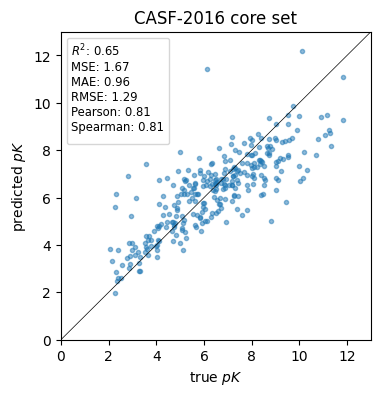

In [4]:
# Setup datamodule
datamodule = GrailDataModule(
    DATASET_ROOT,
    batch_size=params["batch_size"],
    split=params["data_split"],
)
datamodule.setup()

predictions = trainer.predict(
    model=model, dataloaders=datamodule.test_dataloader()
)
y_pred = torch.cat(predictions)
y_true = datamodule.test_data.y

calc_metrics_and_plot(y_true.numpy(), y_pred.numpy(), "CASF-2016 core set")

Processing...
  0%|          | 0/115 [00:00<?, ?it/s]

100%|██████████| 115/115 [00:00<00:00, 163.57it/s]
Done!


No data splitting is applied.
Number of graphs in the dataset: 115


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_2189318/4094850966.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=metrics_text, loc='upper left', fontsize='small', title_fontsize='small')


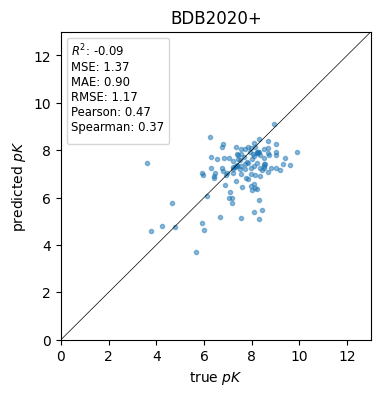

Processing...
100%|██████████| 23/23 [00:00<00:00, 169.11it/s]
Done!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No data splitting is applied.
Number of graphs in the dataset: 23


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_2189318/4094850966.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=metrics_text, loc='upper left', fontsize='small', title_fontsize='small')


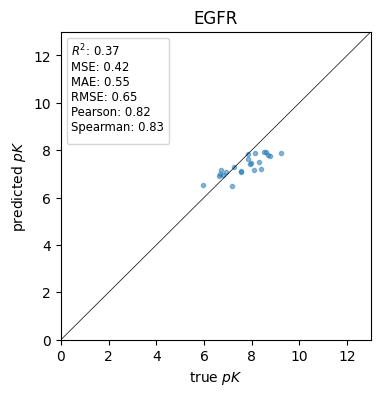

Processing...
100%|██████████| 40/40 [00:00<00:00, 167.59it/s]
Done!
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No data splitting is applied.
Number of graphs in the dataset: 40


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_2189318/4094850966.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=metrics_text, loc='upper left', fontsize='small', title_fontsize='small')


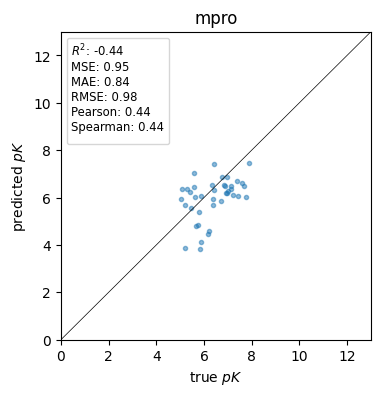

In [5]:
# Setup datamodule
datasets = ["BDB2020+", "EGFR", "mpro"]
for dataset in datasets:
    datamodule = GrailDataModule(
        os.path.join(PROJECT_ROOT, "data", dataset),
        batch_size=params["batch_size"],
        split=None,
    )
    datamodule.setup()
    predictions = trainer.predict(
        model=model, dataloaders=datamodule.full_dataloader()
    )
    y_pred = torch.cat(predictions)
    y_true = datamodule.full_data.y
    calc_metrics_and_plot(y_true.numpy(), y_pred.numpy(), dataset)

/data/local/miniforge3/envs/grape/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1.post0, which is newer than your current Lightning version: v2.5.1
/data/local/miniforge3/envs/grape/lib/python3.11/site-packages/torch_geometric/nn/models/mlp.py:102: UserWarning: Argument `batch_norm` is deprecated, please use `norm` to specify normalization layer.
  warnings.warn("Argument `batch_norm` is deprecated, "
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of training graphs: 11513
Number of validation graphs: 2422
Number of test graphs: 4860


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_2189318/4094850966.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=metrics_text, loc='upper left', fontsize='small', title_fontsize='small')


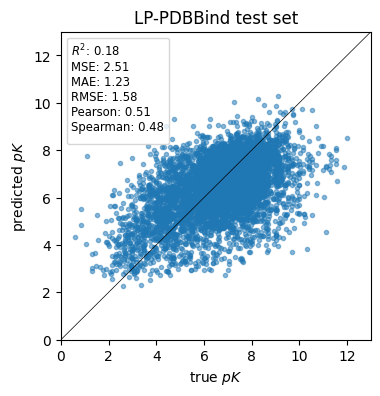

In [6]:
# Define global variables
PROJECT_ROOT = os.path.dirname(os.getcwd())
MODEL = GrailRegressor
#VS_MODEL_NUMBER = "120"
#MODEL_PATH = os.path.join(PROJECT_ROOT, "logs", MODEL.__name__, f"version_{VS_MODEL_NUMBER}")
MODEL_PATH = os.path.join(PROJECT_ROOT, "trained_model", "griphin_model_lppdb")
params = yaml.load(
    open(os.path.join(MODEL_PATH, "hparams.yaml"), "r"), Loader=yaml.FullLoader
)
#model = load_model_from_path(MODEL_PATH, MODEL)
model = MODEL.load_from_checkpoint(
            os.path.join(MODEL_PATH, "model.ckpt"), map_location=torch.device("cpu")
        )
DATASET_ROOT = os.path.join(PROJECT_ROOT, "data", params["data_set"])

# Load the model
trainer = Trainer(
    num_nodes=1,
    devices=1,
    accelerator="gpu",
    logger=False,
    log_every_n_steps=2,
)

# Setup datamodule
datamodule = GrailDataModule(
    DATASET_ROOT,
    batch_size=params["batch_size"],
    split=params["data_split"],
)
datamodule.setup()

predictions = trainer.predict(
    model=model, dataloaders=datamodule.test_dataloader()
)
y_pred = torch.cat(predictions)
y_true = datamodule.test_data.y

calc_metrics_and_plot(y_true.numpy(), y_pred.numpy(), "LP-PDBBind test set")